In [1]:
import os
import random
import math

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/brs426/data'
annotation_csv = '/scratch/brs426/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 132)
val_labeled_scene_index = np.arange(132, 134)
test_labeled_scene_index = np.arange(132, 134)

from helper import compute_ats_bounding_boxes, compute_ts_road_map

In [2]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [3]:
class_label = 0
class_dict = dict()
reverse_class_dict = []
for i in range(0, 800, 50):
    for j in range(0, 800, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))

In [4]:
class_dict

{(0, 0): 0,
 (0, 50): 1,
 (0, 100): 2,
 (0, 150): 3,
 (0, 200): 4,
 (0, 250): 5,
 (0, 300): 6,
 (0, 350): 7,
 (0, 400): 8,
 (0, 450): 9,
 (0, 500): 10,
 (0, 550): 11,
 (0, 600): 12,
 (0, 650): 13,
 (0, 700): 14,
 (0, 750): 15,
 (50, 0): 16,
 (50, 50): 17,
 (50, 100): 18,
 (50, 150): 19,
 (50, 200): 20,
 (50, 250): 21,
 (50, 300): 22,
 (50, 350): 23,
 (50, 400): 24,
 (50, 450): 25,
 (50, 500): 26,
 (50, 550): 27,
 (50, 600): 28,
 (50, 650): 29,
 (50, 700): 30,
 (50, 750): 31,
 (100, 0): 32,
 (100, 50): 33,
 (100, 100): 34,
 (100, 150): 35,
 (100, 200): 36,
 (100, 250): 37,
 (100, 300): 38,
 (100, 350): 39,
 (100, 400): 40,
 (100, 450): 41,
 (100, 500): 42,
 (100, 550): 43,
 (100, 600): 44,
 (100, 650): 45,
 (100, 700): 46,
 (100, 750): 47,
 (150, 0): 48,
 (150, 50): 49,
 (150, 100): 50,
 (150, 150): 51,
 (150, 200): 52,
 (150, 250): 53,
 (150, 300): 54,
 (150, 350): 55,
 (150, 400): 56,
 (150, 450): 57,
 (150, 500): 58,
 (150, 550): 59,
 (150, 600): 60,
 (150, 650): 61,
 (150, 700): 62,

In [5]:
reverse_class_dict[7]

(0, 350)

In [6]:
def collate_fn(batch):
    BLOCK_SIZE = 5
    images = []
    target = []
    road_maps = []
    road_bins = []
    bbs = []
    target_counts = []
    target_x_off = []
    target_y_off = []
    for x in batch:
        
        grid = []
        # Get road_image and cast it to float
        road_image = torch.as_tensor(x[2])
        road_maps.append(road_image)
        road_image = road_image.float()
        
        # Split up into blocks and assign pixel value for block
        for x_ in range(0, 800, BLOCK_SIZE):
            for y in range(0, 800, BLOCK_SIZE):
                block = road_image[x_:x_+BLOCK_SIZE, y:y+BLOCK_SIZE]
                score = torch.sum(block).item()
                # If more than have the pixels are 1, classify as road
                if score > (BLOCK_SIZE**2) / 2:
                    grid.append(1.0)
                else:
                    grid.append(0.0)
                
        road_bins.append(torch.Tensor(grid))
        
        # Collect six images for this sample. 
        six_images = []
        for i in range(6):
            six_images.append(torch.Tensor(x[0][i]))
        
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bins_x_off = np.zeros(256)
        bins_y_off = np.zeros(256)
        bins = np.zeros(256)
        counts = np.zeros(90)
        count = 0
        
        for i, corners in enumerate(bb_tens):
#             if x[1]['category'][i] not in [1, 3, 6, 8]:
            # Get its four bird's-eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400

            # Grab the current bounding box. 
            current_bbs.append((xs, ys))

            # Find the bin/grid cell it falls in, get its class mapping. 
            center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
            key = (round_down(center_x), round_down(center_y))
            
            bin_center_x, bin_center_y = key[0] + 25, key[1] + 25
            
            x_offset = center_x - bin_center_x
            y_offset = center_y - bin_center_y
            
            x_offset /= 25
            y_offset /= 25
            
            if key not in class_dict:
                print(key)
            bin_id = class_dict[key]
            bins[bin_id] = 1
            count += 1
            
            bins_x_off[bin_id] = x_offset
            bins_y_off[bin_id] = y_offset
            
            
        
        counts[count] = 1

        # Label Smoothing #
        if count > 10 and count < 88:
            counts[count+1] = 0.2
            counts[count-1] = 0.2
        target_counts.append(torch.Tensor(counts))
        
        images.append(torch.stack(six_images))
                
        target.append(torch.Tensor(bins))
        target_x_off.append(torch.Tensor(bins_x_off))
        target_y_off.append(torch.Tensor(bins_y_off))
        
        bbs.append(current_bbs)
                
    boom = torch.stack(images), torch.stack(target), torch.stack(road_maps), bbs, torch.stack(target_counts), torch.stack(road_bins), torch.stack(target_x_off), torch.stack(target_y_off)
    return boom

In [7]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()

train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.4, hue = (-0.5, 0.5)),
        transforms.Grayscale(3),
#         transforms.RandomAffine(3),
    ]),
    transforms.ToTensor(),
])


labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=16, num_workers=5, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=16, num_workers=5, shuffle=True, collate_fn=collate_fn)



#### Testing

In [30]:
sample, target, road_img, bbs, counts, road_bins, x_off, y_off = iter(train_loader).next()

In [31]:
idx = -1

In [32]:
idx += 1

In [33]:
print(torch.argmax(counts[idx]))

tensor(7)


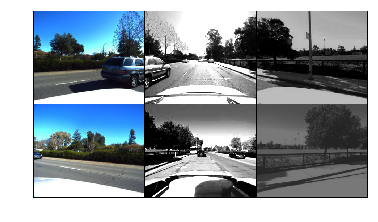

In [34]:
plt.imshow(torchvision.utils.make_grid(sample[idx], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

(150, 350)
tensor([0.7109])
tensor([0.9240])
(200, 300)
tensor([0.7759])
tensor([0.0590])
(250, 200)
tensor([-0.9794])
tensor([-0.9155])
(450, 350)
tensor([-0.4932])
tensor([-0.5276])
(500, 200)
tensor([0.3379])
tensor([-0.9032])
(700, 300)
tensor([0.5232])
tensor([0.2082])
(700, 400)
tensor([-0.2559])
tensor([0.3215])


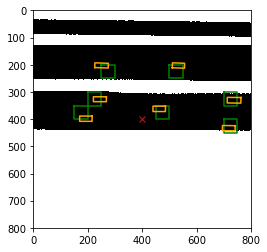

In [40]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

# `target` is 32 by 81. Find the indices where there's a 1. 
bin_ids = (target[idx] == 1).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    print(class_box)
    print(x_off[idx][bin_id])
    print(y_off[idx][bin_id])
    draw_box(ax, class_box, 'green')
    
def append_first_to_last(tens):
    ret = torch.cat((tens, torch.as_tensor([tens[0]])))
    return ret

    
for bb in bbs[idx]:
    ax.plot(append_first_to_last(bb[0]), append_first_to_last(bb[1]), color='orange')
    


In [36]:
def draw_box(ax, class_box, color):
    box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50, class_box[0]]
    box_ys = [class_box[1], class_box[1]+50, class_box[1]+50, class_box[1], class_box[1]]
    ax.plot(box_xs, box_ys, color=color)

### model

In [8]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet50()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 180 * 6
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(2048, 180)),
            ('drop', nn.Dropout(p = 0.5)),
            ('relu', nn.ReLU()),
        ]))
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.concat_dim, 256)),
        ]))
        
        self.x_offset = nn.Sequential(OrderedDict([
            ('xoff1', nn.Linear(self.concat_dim, 256)),
            ('tanh1', nn.Tanh())
        ]))
        
        self.y_offset = nn.Sequential(OrderedDict([
            ('yoff1', nn.Linear(self.concat_dim, 256)),
            ('tanh2', nn.Tanh())
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 90))
        ]))
        
        self.segmentation = nn.Sequential(OrderedDict([
            ('linear1_segmentation', nn.Linear(self.concat_dim, 25600)),
            ('sigmoid', nn.Sigmoid())
        ]))
        
    def forward(self, x):
        batch_size = x.shape[0]
        num_images = x.shape[1]
        channels = x.shape[2]
        height = x.shape[3]
        width = x.shape[4]
        # Reshape here
        x = x.view(-1, channels, height, width)
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        return self.classification(x), self.counts(x), self.segmentation(x), self.x_offset(x), self.y_offset(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()

# Weighting certain classes more. 
# positive_weight = torch.ones(256).to(device)
# for (x, y), bin_id in class_dict.items():
#     if abs(x - 400) <= 200 and abs(y - 400) <= 200:
#         positive_weight[bin_id] = 2

# for name, param in model.encoder.named_parameters():
#     if("bn" not in name):
#         param.requires_grad = False
        
# unfreeze_layers = [model.encoder.layer3, model.encoder.layer4]
# for layer in unfreeze_layers:
#     for param in layer.parameters():
#         param.requires_grad = True
        
model = model.to(device)
bin_criterion = nn.BCEWithLogitsLoss()
count_criterion = nn.BCEWithLogitsLoss()
segmentation_criterion = nn.BCELoss()
x_offset_criterion = nn.MSELoss()
y_offset_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
best_val_loss = 100

In [10]:
def train():
    model.train()
    labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
    train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=10, num_workers=10, shuffle=True, collate_fn=collate_fn)
    
    train_losses = []
    bin_losses = []
    count_losses = []
    segmentation_losses = []
    x_off_losses = []
    y_off_losses = []
    for i, (sample, target, road_img, bbs, target_count, road_bins, target_x_off, target_y_off) in enumerate(train_loader):
        optimizer.zero_grad()

        sample = sample.to(device)
        target = target.to(device)
        target_count = target_count.to(device)
        road_bins = road_bins.to(device)
        target_x_off = target_x_off.to(device)
        target_y_off = target_y_off.to(device)
        
        y_hat, y_count, segmentation, x_offset, y_offset = model(sample)
        
        bin_loss = bin_criterion(y_hat, target.float())
        count_loss = count_criterion(y_count, target_count.float())
        segmentation_loss = segmentation_criterion(segmentation, road_bins.float())
        
        
        x_off_loss = 0
        y_off_loss = 0
        for idx, vector in enumerate(target):
            # Get the ids that are equal to 1. 
            bin_ids = (target[idx] == 1).nonzero()
            x_off_loss += x_offset_criterion(x_offset[idx][bin_ids], target_x_off[idx][bin_ids])
            y_off_loss += y_offset_criterion(y_offset[idx][bin_ids], target_y_off[idx][bin_ids])

        loss = bin_loss + count_loss + segmentation_loss + 0.05 * x_off_loss + 0.05 * y_off_loss
        
        train_losses.append(loss.item())
        bin_losses.append(bin_loss.item())
        count_losses.append(count_loss.item())
        segmentation_losses.append(segmentation_loss.item())
        x_off_losses.append(0.05 * x_off_loss.item())
        y_off_losses.append(0.05 * y_off_loss.item())

        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                50. * i / len(train_loader), loss.item()))
            
    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
    print("Average Train Bin Epoch Loss: ", np.mean(bin_losses))
    print("Average Train Count Epoch Loss: ", np.mean(count_losses))
    print("Average Train Segmentation Epoch Loss: ", np.mean(segmentation_losses))
    print("Average Train X-Offset Epoch Loss: ", np.mean(x_off_losses))
    print("Average Train Y-Offset Epoch Loss: ", np.mean(y_off_losses))
            
def val():
    model.eval()
    val_losses = []
    bin_losses = []
    count_losses = []
    segmentation_losses = []
    x_off_losses = []
    y_off_losses = []
    count_correct = 0
    count_off_by_1 = 0
    total_count = 0
    bin_correct = 0
    total_bins = 0
    for i, (sample, target, road_img, bbs, target_count, road_bins, target_x_off, target_y_off) in enumerate(val_loader):

        model.eval()

        sample = sample.to(device)
        target = target.to(device)
        road_bins = road_bins.to(device)
        target_count = target_count.to(device)
        target_x_off = target_x_off.to(device)
        target_y_off = target_y_off.to(device)

        with torch.no_grad():
            y_hat, y_count, segmentation, x_offset, y_offset = model(sample)
            
            bin_loss = bin_criterion(y_hat, target.float())
            count_loss = count_criterion(y_count, target_count.float())
            segmentation_loss = segmentation_criterion(segmentation, road_bins.float())
            
            x_off_loss = 0
            y_off_loss = 0
            for idx, vector in enumerate(target):
                # Get the ids that are equal to 1. 
                bin_ids = (target[idx] == 1).nonzero()
                x_off_loss += x_offset_criterion(x_offset[idx][bin_ids], target_x_off[idx][bin_ids])
                y_off_loss += y_offset_criterion(y_offset[idx][bin_ids], target_y_off[idx][bin_ids])
                
            loss = bin_loss + count_loss + segmentation_loss + 0.05 * x_off_loss + 0.05 * y_off_loss

            val_losses.append(loss.item())
            bin_losses.append(bin_loss.item())
            count_losses.append(count_loss.item())
            segmentation_losses.append(segmentation_loss.item())
            x_off_losses.append(0.05 * x_off_loss.item())
            y_off_losses.append(0.05 * y_off_loss.item())
            
    print("Average Validation Epoch Loss: ", np.mean(val_losses))
    print("Average Validation Bin Epoch Loss: ", np.mean(bin_losses))
    print("Average Validation Count Epoch Loss: ", np.mean(count_losses))
    print("Average Validation Segmentation Epoch Loss: ", np.mean(segmentation_losses))
    print("Average Validation X-Offset Epoch Loss: ", np.mean(x_off_losses))
    print("Average Validation Y-Offset Epoch Loss: ", np.mean(y_off_losses))
#     print("\tAverage Validation Count Accuracy: ", 100*count_correct/total_count)
#     print("\tAverage Validation Count-off-by-1 Accuracy: ", 100*count_off_by_1/total_count)
#     if total_bins != 0:
#         print("\tAverage Validation Bin Accuracy: ", 100*bin_correct/total_bins)
#     print("\n")
    global best_val_loss
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(model.state_dict(), '/scratch/vr1059/all_six_images_classify_count_offset.pt')

In [ ]:
epochs = 100
for epoch in range(epochs):
    train()
    val()

Train Epoch: 0 [0/3276 (0%)]	Loss: 2.525649
Train Epoch: 0 [500/3276 (8%)]	Loss: 1.369438
Train Epoch: 0 [1000/3276 (15%)]	Loss: 1.156603
Train Epoch: 0 [1500/3276 (23%)]	Loss: 1.085791
Train Epoch: 0 [2000/3276 (30%)]	Loss: 1.081921
Train Epoch: 0 [2500/3276 (38%)]	Loss: 1.035587
Train Epoch: 0 [3000/3276 (46%)]	Loss: 1.009162

Average Train Epoch Loss:  1.1585347372584227
Average Train Bin Epoch Loss:  0.23283358122699144
Average Train Count Epoch Loss:  0.10069402543509878
Average Train Segmentation Epoch Loss:  0.4272751302072188
Average Train X-Offset Epoch Loss:  0.21910355628990547
Average Train Y-Offset Epoch Loss:  0.17862843585813917
Average Validation Epoch Loss:  1.179866187274456
Average Validation Bin Epoch Loss:  0.23227671813219786
Average Validation Count Epoch Loss:  0.0677193864248693
Average Validation Segmentation Epoch Loss:  0.3983976896852255
Average Validation X-Offset Epoch Loss:  0.2697022318840027
Average Validation Y-Offset Epoch Loss:  0.211770149320364
Tr

Train Epoch: 8 [2500/3276 (38%)]	Loss: 0.752709
Train Epoch: 8 [3000/3276 (46%)]	Loss: 0.800835

Average Train Epoch Loss:  0.7557330718491135
Average Train Bin Epoch Loss:  0.17603951588091327
Average Train Count Epoch Loss:  0.054650306247356464
Average Train Segmentation Epoch Loss:  0.26680222903264733
Average Train X-Offset Epoch Loss:  0.16240386848406096
Average Train Y-Offset Epoch Loss:  0.09583714477172713
Average Validation Epoch Loss:  1.0472346358001232
Average Validation Bin Epoch Loss:  0.21512788720428944
Average Validation Count Epoch Loss:  0.06287957448512316
Average Validation Segmentation Epoch Loss:  0.29695599153637886
Average Validation X-Offset Epoch Loss:  0.260307177901268
Average Validation Y-Offset Epoch Loss:  0.21196398884058001
Train Epoch: 9 [0/3276 (0%)]	Loss: 0.680860
Train Epoch: 9 [500/3276 (8%)]	Loss: 0.682982
Train Epoch: 9 [1000/3276 (15%)]	Loss: 0.816746
Train Epoch: 9 [1500/3276 (23%)]	Loss: 0.867852
Train Epoch: 9 [2000/3276 (30%)]	Loss: 0.825

Train Epoch: 17 [0/3276 (0%)]	Loss: 0.605618
Train Epoch: 17 [500/3276 (8%)]	Loss: 0.723889
Train Epoch: 17 [1000/3276 (15%)]	Loss: 0.729402
Train Epoch: 17 [1500/3276 (23%)]	Loss: 0.522662
Train Epoch: 17 [2000/3276 (30%)]	Loss: 0.621565
Train Epoch: 17 [2500/3276 (38%)]	Loss: 0.712729
Train Epoch: 17 [3000/3276 (46%)]	Loss: 0.529743

Average Train Epoch Loss:  0.6185214594915146
Average Train Bin Epoch Loss:  0.1585164233224421
Average Train Count Epoch Loss:  0.04827019219036873
Average Train Segmentation Epoch Loss:  0.20749923677706136
Average Train X-Offset Epoch Loss:  0.13965369195836347
Average Train Y-Offset Epoch Loss:  0.06458191408253297
Average Validation Epoch Loss:  1.0371753610670567
Average Validation Bin Epoch Loss:  0.20800682250410318
Average Validation Count Epoch Loss:  0.061475571477785707
Average Validation Segmentation Epoch Loss:  0.28634096402674913
Average Validation X-Offset Epoch Loss:  0.270939813554287
Average Validation Y-Offset Epoch Loss:  0.21041219

Train Epoch: 25 [1500/3276 (23%)]	Loss: 0.450068
Train Epoch: 25 [2000/3276 (30%)]	Loss: 0.507724
Train Epoch: 25 [2500/3276 (38%)]	Loss: 0.440036
Train Epoch: 25 [3000/3276 (46%)]	Loss: 0.570038

Average Train Epoch Loss:  0.5468076815510668
Average Train Bin Epoch Loss:  0.14865542305406274
Average Train Count Epoch Loss:  0.04455997780669571
Average Train Segmentation Epoch Loss:  0.18175021988317008
Average Train X-Offset Epoch Loss:  0.11955531642931264
Average Train Y-Offset Epoch Loss:  0.05228674100121347
Average Validation Epoch Loss:  1.0199095383286476
Average Validation Bin Epoch Loss:  0.20236483868211508
Average Validation Count Epoch Loss:  0.06364919990301132
Average Validation Segmentation Epoch Loss:  0.2582975560799241
Average Validation X-Offset Epoch Loss:  0.2790671713650227
Average Validation Y-Offset Epoch Loss:  0.21653076559305193
Train Epoch: 26 [0/3276 (0%)]	Loss: 0.586692
Train Epoch: 26 [500/3276 (8%)]	Loss: 0.500722
Train Epoch: 26 [1000/3276 (15%)]	Loss:


Average Train Epoch Loss:  0.49743718853810936
Average Train Bin Epoch Loss:  0.14111690793368148
Average Train Count Epoch Loss:  0.04114723041449196
Average Train Segmentation Epoch Loss:  0.16493866758466494
Average Train X-Offset Epoch Loss:  0.10460024363384014
Average Train Y-Offset Epoch Loss:  0.04563413666243233
Average Validation Epoch Loss:  1.001634493470192
Average Validation Bin Epoch Loss:  0.20386551227420568
Average Validation Count Epoch Loss:  0.0624683138448745
Average Validation Segmentation Epoch Loss:  0.24750246945768595
Average Validation X-Offset Epoch Loss:  0.28826966136693954
Average Validation Y-Offset Epoch Loss:  0.1995285153388977
Train Epoch: 34 [0/3276 (0%)]	Loss: 0.368277
Train Epoch: 34 [500/3276 (8%)]	Loss: 0.593633
Train Epoch: 34 [1000/3276 (15%)]	Loss: 0.528548
Train Epoch: 34 [1500/3276 (23%)]	Loss: 0.515859
Train Epoch: 34 [2000/3276 (30%)]	Loss: 0.521510
Train Epoch: 34 [2500/3276 (38%)]	Loss: 0.570472
Train Epoch: 34 [3000/3276 (46%)]	Loss:

Average Validation Epoch Loss:  0.9938587732613087
Average Validation Bin Epoch Loss:  0.20582658145576715
Average Validation Count Epoch Loss:  0.0633002535905689
Average Validation Segmentation Epoch Loss:  0.23465562798082829
Average Validation X-Offset Epoch Loss:  0.28257910013198856
Average Validation Y-Offset Epoch Loss:  0.20749722570180895
Train Epoch: 42 [0/3276 (0%)]	Loss: 0.414681
Train Epoch: 42 [500/3276 (8%)]	Loss: 0.423672
Train Epoch: 42 [1000/3276 (15%)]	Loss: 0.394427
Train Epoch: 42 [1500/3276 (23%)]	Loss: 0.463043
Train Epoch: 42 [2000/3276 (30%)]	Loss: 0.551949
Train Epoch: 42 [2500/3276 (38%)]	Loss: 0.452005
Train Epoch: 42 [3000/3276 (46%)]	Loss: 0.444631

Average Train Epoch Loss:  0.4616292448850667
Average Train Bin Epoch Loss:  0.13550186307146783
Average Train Count Epoch Loss:  0.03872305361508596
Average Train Segmentation Epoch Loss:  0.1543143324599397
Average Train X-Offset Epoch Loss:  0.09246364161372185
Average Train Y-Offset Epoch Loss:  0.04062635

Train Epoch: 50 [0/3276 (0%)]	Loss: 0.404966
Train Epoch: 50 [500/3276 (8%)]	Loss: 0.458979
Train Epoch: 50 [1000/3276 (15%)]	Loss: 0.453123
Train Epoch: 50 [1500/3276 (23%)]	Loss: 0.447854
Train Epoch: 50 [2000/3276 (30%)]	Loss: 0.453708
Train Epoch: 50 [2500/3276 (38%)]	Loss: 0.399273
Train Epoch: 50 [3000/3276 (46%)]	Loss: 0.416211

Average Train Epoch Loss:  0.43852776943183525
Average Train Bin Epoch Loss:  0.1314563690344008
Average Train Count Epoch Loss:  0.03650854839716197
Average Train Segmentation Epoch Loss:  0.1473191399127245
Average Train X-Offset Epoch Loss:  0.08438822916004715
Average Train Y-Offset Epoch Loss:  0.038855479793941106
Average Validation Epoch Loss:  1.0159697718918324
Average Validation Bin Epoch Loss:  0.2044970067217946
Average Validation Count Epoch Loss:  0.06490784836933017
Average Validation Segmentation Epoch Loss:  0.23988137301057577
Average Validation X-Offset Epoch Loss:  0.29544949233531953
Average Validation Y-Offset Epoch Loss:  0.2112340

In [5]:
# 60 x 200
# 10 x 1200
x = torch.randn((12, 5))

### Submission

In [6]:
# Compute threat scores
def reconstruct_from_bins(bins, block_size, threshold):
    print(bins.shape)
    road_map = torch.zeros((800, 800))
    idx = 0
    for x in range(0, 800, block_size):
        for y in range(0, 800, block_size):
            road_map[x:x+block_size, y:y+block_size] = bins[idx]
            idx += 1
    return road_map > threshold

def faster_reconstruct_from_bins(bins, block_size, threshold):
    downsampled_roadmap = bins.reshape(1, 1, 800 // block_size, 800 // block_size)
    up = nn.Upsample(size=(800, 800), mode='nearest')
    road_map = up(downsampled_roadmap)
    return road_map > threshold

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel().to(device)
model.load_state_dict(torch.load('/scratch/brs426/all_six_images_classify_count_better.pt'))

<All keys matched successfully>

In [15]:
model.eval()

threat_scores = 0
threshold = 0.4

with torch.no_grad():
    for i, (sample, target, road_img, bbs, target_count, road_bins) in enumerate(val_loader):
        sample = sample.to(device)
        target = target.to(device)
        road_bins = road_bins.to(device)
        target_count = target_count.to(device)
        
        y_hat, y_count, segmentation = model(sample)
        segmentation = segmentation.squeeze()
        road_img = road_img.squeeze()
        
        reconstructed_road_map = faster_reconstruct_from_bins(segmentation, 5, threshold).cpu()
        ts_road_map = compute_ts_road_map(road_img,reconstructed_road_map)
        threat_scores += ts_road_map
    
    print("Average threat score", threat_scores / len(val_loader))
        
        
        
        
    

torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])
torch.Size([25600])


In [15]:
def collate_fn(batch):
    BLOCK_SIZE = 5
    images = []
    target = []
    road_maps = []
    road_bins = []
    bbs = []
    target_counts = []
    for x in batch:
        
        grid = []
        # Get road_image and cast it to float
        road_image = torch.as_tensor(x[2])
        road_maps.append(road_image)
        road_image = road_image.float()
        
        # Split up into blocks and assign pixel value for block
        for x_ in range(0, 800, BLOCK_SIZE):
            for y in range(0, 800, BLOCK_SIZE):
                block = road_image[x_:x_+BLOCK_SIZE, y:y+BLOCK_SIZE]
                score = torch.sum(block).item()
                # If more than have the pixels are 1, classify as road
                if score > (BLOCK_SIZE**2) / 2:
                    grid.append(1.0)
                else:
                    grid.append(0.0)
                
        road_bins.append(torch.Tensor(grid))
        
        # Collect six images for this sample. 
        six_images = []
        for i in range(6):
            six_images.append(torch.Tensor(x[0][i]))
        
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bins = np.zeros(256)
        counts = np.zeros(90)
        count = 0
        
        for i, corners in enumerate(bb_tens):
#             if x[1]['category'][i] not in [1, 3, 6, 8]:
            # Grab the current bounding box. 
            current_bbs.append(corners)

            # Get its four bird's-eye view coordinates.
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400

            # Find the bin/grid cell it falls in, get its class mapping. 
            center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
            key = (round_down(center_x), round_down(center_y))
            if key not in class_dict:
                print(key)
            bin_id = class_dict[key]
            bins[bin_id] = 1
            count += 1
            
        
        counts[count] = 1

        # Label Smoothing #
        if count > 10 and count < 88:
            counts[count+1] = 0.2
            counts[count-1] = 0.2
        target_counts.append(torch.Tensor(counts))
        
        images.append(torch.stack(six_images))
                
        target.append(torch.Tensor(bins))
        
        bbs.append(current_bbs)
                
    boom = torch.stack(images), torch.stack(target), torch.stack(road_maps), bbs, torch.stack(target_counts), torch.stack(road_bins)
    return boom

In [16]:
test_transform = transforms.ToTensor()
labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_labeled_scene_index,
                                  transform=test_transform,
                                  extra_info=True
                                 )

test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [27]:

class_label = 0
class_dict = dict()
reverse_class_dict = []
for i in range(0, 800, 50):
    for j in range(0, 800, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))


model.eval()

threat_scores = 0

with torch.no_grad():
    for i, (sample, target, road_img, bbs, target_count, road_bins) in enumerate(test_loader):
        bb_samples = []
        sample = sample.to(device)
        target = target.to(device)
        road_bins = road_bins.to(device)
        target_count = target_count.to(device)
        
        y_hat, y_count, segmentation = model(sample)
        
        if torch.argmax(y_count).item() > 15:
            result = torch.topk(y_hat, k = 6 + torch.argmax(y_count).item())
            pred_ids = result.indices
        else:
            result = torch.topk(y_hat, k = torch.argmax(y_count).item())
            pred_ids = result.indices

        bounding_boxes = []
        for idx in pred_ids[0]:
            bin_x, bin_y = reverse_class_dict[idx.item()]

            xs = torch.Tensor([bin_x, bin_x, bin_x + 50, bin_x + 50]).double()
            ys = torch.Tensor([bin_y+16, bin_y+36, bin_y+16, bin_y+36]).double()

            xs = xs - 400
            ys = 800 - ys # right-side up
            ys = ys - 400

            xs /= 10.
            ys /= 10.

            coords = torch.stack((xs, ys))
            bounding_boxes.append(coords)

        bounding_boxes = torch.stack(bounding_boxes).double().cuda()
        bb_samples.append(bounding_boxes)
        bb_samples = tuple(bb_samples)
                
        bb_samples = bb_samples[0].cpu()
        bbs = torch.stack(bbs[0]).cpu()
        ts_bounding_box = compute_ats_bounding_boxes(bb_samples, bbs)
        
        threat_scores += ts_bounding_box
    
    print("Average threat score", threat_scores / len(test_loader))        

Average threat score tensor(0.0066)


In [ ]:
# 0.253 val bin loss

# Random Affine 3 degrees
# 0.263 val bin loss


# Need to do 5 * bin_loss + count_loss or something like that. Also more extreme Random Affine maybe?

# Random Affine 5 degrees
# 0.266 val bin loss

# Took out Random Affine. 
# 0.268 val bin loss

# Increased compress dim from 128 to 200. 
# 0.259 val bin loss

# 5 * bin_loss + count_loss
# 0.249 + 0.055

# 8 *
# 0.251 + 0.054

# 8*, RandomAffine(3)
# 0.255

# 8*, RandomAffine(3), weight_decay 0.1

# 10 *, RandomAffine(3)
# 0.259

# 8 *, Normalize (mean, std)
# 0.26

# 8 *, Dropout
# 0.241, 0.253

# 5 *, Dropout
# 0.254

# 11 *, Dropout
# 0.249

# Want to try positive-weights for classes within 200 to 600. 
# Want to get the model to get those classes correct. 

# Mixup 0.2, 1 *, Dropout
# (0.244, 0.053), 


## Testing Model Output

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet50()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 200 * 6
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(2048, 200)),
            ('drop', nn.Dropout(p = 0.5)),
            ('relu', nn.ReLU()),
        ]))
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.concat_dim, 256)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 90))
        ]))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        return self.classification(x), self.counts(x)

In [ ]:
model = SimpleModel()
model.load_state_dict(torch.load('all_six_images_classify_count.pt'))
model.cuda()
model.eval()

In [ ]:
class_label = 0
class_dict = dict()
reverse_class_dict = []
for i in range(0, 800, 50):
    for j in range(0, 800, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))

In [ ]:
def get_bounding_boxes(samples):
    
    # samples is (batch_size, 6, 3, 256, 306)
    
    # You need to return a tuple with size batch_size and each element is a cuda tensor [N, 2, 4]
    # where N is the number of bounding boxes. 
    
    # Okay so I have my model. 
    # 
    
    bb_samples = []
    
    for x in samples:
        preds_class, preds_count = model(x)
        
        # preds class is a 256-dimensional tensor, filled with probabilities
        # I need to find the `preds_count` top indices with the top values.
        
        
        result = torch.topk(preds_class, k = torch.argmax(preds_count).item())
        pred_ids = result.indices
        
        bounding_boxes = []
        for idx in pred_ids[0]:
            buck_x, buck_y = reverse_class_dict[idx.item()]
            
            xs = torch.as_tensor([buck_x, buck_x, buck_x + 50, buck_x + 50])
            ys = torch.as_tensor([buck_y+16, buck_y+36, buck_y+16, buck_y+36])
            
            xs = xs - 400
            ys = 800 - ys # right-side up
            ys = ys - 400
            
            xs /= 10
            ys /= 10
               
            coords = torch.stack((xs, ys))
            bounding_boxes.append(coords)
            
        bounding_boxes = torch.stack(bounding_boxes).cuda()
        bb_samples.append(bounding_boxes)
    
    return tuple(bb_samples)
    

In [ ]:
sample, target, road_img, bbs, counts = iter(val_loader).next()

In [ ]:
sample = sample.cuda()

In [ ]:
boom = get_bounding_boxes(sample)

In [ ]:
sigmoid_preds = torch.sigmoid(model(sample[idx])[0]).squeeze()

In [ ]:
idx = -1

In [ ]:
idx += 1

In [ ]:
plt.imshow(torchvision.utils.make_grid(sample[idx].cpu().detach(), nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [ ]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

# `target` is 32 by 81. Find the indices where there's a 1. 

bin_ids = (sigmoid_preds > 0.25).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    draw_vish_box(ax, class_box, 'red')
    
bin_ids = (target[idx] == 1).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    draw_vish_box(ax, class_box, 'green')

    
for bb in boom[idx]:
    box = bb.cpu().detach()
    draw_box(ax, box, 'orange')

In [ ]:
torch.stack([box[:, 0], box[:, 1], box[:, 3], box[:, 2], box[:, 0]])

def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)
    return point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400

In [ ]:
def draw_vish_box(ax, class_box, color):
    box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50, class_box[0]]
    box_ys = [class_box[1], class_box[1]+50, class_box[1]+50, class_box[1], class_box[1]]
    ax.plot(box_xs, box_ys, color=color)